In [24]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
from scipy.stats import logistic
import time
import random
import json
import string
import math
import pathlib
import matplotlib.pyplot as plt
sigm = logistic.cdf
from sklearn.preprocessing import normalize
from tqdm import tqdm
import numpy.matlib as mt  
from scipy.sparse import csc_matrix
import scipy
import itertools
from scipy.stats import randint

In [53]:
class Experiments():
  def __init__(self, d, p, Q):
    self.dim = d
    self.p = p
    self.Q = Q
    self.x_solve = np.random.uniform(-self.Q,self.Q, size=((self.dim, 1)))
    self.A_problem = self.sample_A_B()
    self.c_problem = self.A_problem @ self.x_solve
    self.x_start = np.random.uniform(-self.Q,self.Q, size=((self.dim, 1)))

    pass

  def Objective_fuction_F(self, x):
    function = self.A_problem @ x - self.c_problem
    Func_Itog = np.linalg.norm(function)**2
    return Func_Itog
  
  def Objective_fuction_F_i(self, x, ind):
    function = self.A_problem[ind] @ x - self.c_problem[ind]
    Func_Itog = np.linalg.norm(function)**2
    return Func_Itog


  def sample_A_B(self):
    vec = np.random.uniform(-self.Q,self.Q, size=((self.p, self.dim)))
    vec /= np.linalg.norm(vec)
    return vec

  def sample_spherical(self):

    vec = np.random.randn(self.dim, 1)
    vec /= np.linalg.norm(vec)
    return vec

  def compute_Kernal(self, beta, r):

    if (beta == 1 or beta == 2):
      Kernal = 3*r
    elif (beta == 3 or beta == 4):
      Kernal = ((15*r) / 4) * (5 - 7 * r**3)
    elif (beta == 5 or beta == 6):
      Kernal = ((195*r) / 64) * (99 * r**4 - 126 * r**2 + 35)
    
    return Kernal
  
  def noise(self, beta, Batch, eps=1e-4):
    if Batch > 1 and Batch <= 15000:
      delta = math.sqrt(eps**3 / self.dim)
    else:
      delta = math.sqrt(math.pow(eps, (3.0 * beta + 1)/(4.0 * (beta - 1))) * math.sqrt(Batch) / self.dim)
    return np.random.normal(0, delta, 2)


  def Approximation_of_gradient_our_paper(self, x, beta, gamma, Batch):
    xi_1, xi_2 = self.noise(beta, Batch, 1e-4)
    r = np.random.uniform(-1,1)
    e = self.sample_spherical()
    Kernal = self.compute_Kernal(beta, r)
    # cost_function_1 = self.Objective_fuction_F(x + gamma*r*e) 
    # cost_function_2 = self.Objective_fuction_F(x - gamma*r*e)
    inds = randint.rvs(low=0, high=self.p, size=Batch)
    cost_function_1 = self.Objective_fuction_F_i(x + gamma*r*e, inds) + xi_1
    cost_function_2 = self.Objective_fuction_F_i(x - gamma*r*e, inds) + xi_2
    grad_kernal = ((cost_function_1 - cost_function_2)* self.dim * Kernal * e) / (2 * gamma)
    return grad_kernal

  def Approximation_of_gradient_Stich_improved(self, x, beta, gamma, Batch):
    xi_1, xi_2 = self.noise(beta, Batch, 1e-3)
    u = self.sample_spherical()
    # cost_function_1 = self.Objective_fuction_F(x + gamma*u) 
    # cost_function_2 = self.Objective_fuction_F(x - gamma*u) 
    cost_function_1 = self.Objective_fuction_F(x + gamma*u) + xi_1
    cost_function_2 = self.Objective_fuction_F(x - gamma*u) + xi_2
    grad_gaussian_improved = ((cost_function_1 - cost_function_2) * self.dim * u) / (2*gamma)
    return grad_gaussian_improved
  
  def Approximation_of_gradient_Stich(self, x, beta, gamma, Batch):
    grad = 0
    for _ in range (0, Batch):
      xi_1, xi_2 = self.noise(beta, Batch, 1e-4)
      u = np.random.randn(self.dim, 1)
      # cost_function_1 = self.Objective_fuction_F(x + gamma*u) 
      # cost_function_2 = self.Objective_fuction_F(x) 
      cost_function_1 = self.Objective_fuction_F(x + gamma*u) + xi_1
      cost_function_2 = self.Objective_fuction_F(x) + xi_2
      grad_Gorb = ((cost_function_1 - cost_function_2) * u) / (gamma)
      grad += grad_Gorb
    grad /= Batch    
    return grad
  
  def Approximation_of_gradient_Gorb(self, x, beta, gamma, Batch):
    grad = 0
    e = self.sample_spherical()
    for _ in range (0, Batch):
      xi_1, xi_2 = self.noise(beta, Batch, 1e-4)
      # cost_function_1 = self.Objective_fuction_F(x + gamma*u) 
      # cost_function_2 = self.Objective_fuction_F(x) 
      cost_function_1 = self.Objective_fuction_F(x + gamma*e) + xi_1
      cost_function_2 = self.Objective_fuction_F(x) + xi_2
      grad_gaussian = ((cost_function_1 - cost_function_2) * e) / (gamma)
      grad += grad_gaussian
    grad /= Batch    
    return grad  

  def Batch_gradient(self, x_Paper, beta, gamma, Batch):
    Grad_Paper = 0
    for _ in range (0, Batch):
      Grad_Paper += self.Approximation_of_gradient_our_paper(x_Paper, beta, gamma, Batch)
    Grad_Paper /= Batch
    return Grad_Paper

  def SGD_comp(self, beta, gamma, Iterations, Batch, stepsize):

    x_Paper = np.copy(self.x_start)
    y_Paper = np.copy(x_Paper)
    z_Paper = np.copy(y_Paper)
    alpha_Paper = 0
    gamma_Paper = 0
    a_Paper = 0

    x_Stich = np.copy(self.x_start)
    y_Stich = np.copy(x_Stich)
    z_Stich = np.copy(y_Stich)
    alpha_Stich = 0
    gamma_Stich = 0
    a_Stich = 0

    x_Stich_improved = np.copy(self.x_start)
    y_Stich_improved = np.copy(x_Stich_improved)
    z_Stich_improved = np.copy(y_Stich_improved)
    alpha_Stich_improved = 0
    gamma_Stich_improved = 0
    a_Stich_improved = 0

    Y_graf_Paper = []
    Y_graf_Stich = []
    Y_graf_Stich_improved = []
    X_graf = []

    rho = max(1.0, (12 * self.dim * beta**3)/Batch)

    for itera in tqdm(range(0, Iterations)):

      Y_graf_Paper.append(self.Objective_fuction_F(x_Paper))
      Y_graf_Stich.append(self.Objective_fuction_F(x_Stich))
      Y_graf_Stich_improved.append(self.Objective_fuction_F(x_Stich_improved))#delete
      X_graf.append(itera)

      grad_Paper = self.Batch_gradient(y_Paper, beta, gamma, Batch)
      grad_Stich = self.Approximation_of_gradient_Stich(y_Stich, beta, gamma, Batch)
      grad_Stich_improved = self.Approximation_of_gradient_Stich_improved(y_Stich_improved, beta, gamma, Batch)#delete

      # update kernel

      x_Paper = y_Paper - stepsize * grad_Paper 
      z_Paper = z_Paper - gamma * stepsize * grad_Paper  

      a_Paper = gamma_Paper * np.sqrt(stepsize * rho)
      gamma_Paper = (rho**(-1) + np.sqrt(rho**(-2) + 4 * gamma_Paper**2)) / 2
      alpha_Paper = (gamma_Paper * stepsize) / (gamma_Paper * stepsize + a_Paper**2)

      y_Paper = alpha_Paper * z_Paper + (1 - alpha_Paper) * x_Paper

      # update gauss
    
      x_Stich = y_Stich - stepsize * grad_Stich 
      z_Stich = z_Stich - gamma * stepsize * grad_Stich

      a_Stich = gamma_Stich * np.sqrt(stepsize * rho)
      gamma_Stich = (rho**(-1) + np.sqrt(rho**(-2) + 4 * gamma_Stich**2)) / 2
      alpha_Stich = (gamma_Stich * stepsize) / (gamma_Stich * stepsize + a_Stich**2)

      y_Stich = alpha_Stich * z_Stich + (1 - alpha_Stich) * x_Stich

      # update l2

      x_Stich_improved = y_Stich_improved - stepsize * grad_Stich_improved 
      z_Stich_improved = z_Stich_improved - gamma * stepsize * grad_Stich_improved

      a_Stich_improved = gamma_Stich_improved * np.sqrt(stepsize * rho)
      gamma_Stich_improved = (rho**(-1) + np.sqrt(rho**(-2) + 4 * gamma_Stich_improved**2)) / 2
      alpha_Stich_improved = (gamma_Stich_improved * stepsize) / (gamma_Stich_improved * stepsize + a_Stich_improved**2)

      y_Stich_improved = alpha_Stich_improved * z_Stich_improved + (1 - alpha_Stich_improved) * x_Stich_improved

    plt.plot(X_graf, Y_graf_Paper, color='crimson', label=f'"Kernel" approximation')
    plt.plot(X_graf, Y_graf_Stich, color='navy', label=f'"Gaussian" approximation')
    plt.plot(X_graf, Y_graf_Stich_improved, color='g', label=f'$L_2$ approximation')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.semilogy()
    plt.ylabel(r"Loss, $f(x) - f(x*)$", fontsize=30)
    plt.xlabel(r"Iterations", fontsize=30)
    plt.legend(loc='best', prop={'size': 10})
    plt.show()
    return(X_graf, Y_graf_Paper, Y_graf_Stich, Y_graf_Stich_improved)
  
  def Our_algorithm(self, beta, gamma, Iterations, Batch, rho):
    x_Paper = np.copy(self.x_start)
    y_Paper = np.copy(x_Paper)
    z_Paper = np.copy(y_Paper)

    alpha_Paper = 0
    gamma_Paper = 0
    a_Paper = 0

    rho = rho

    L = max(np.real(np.linalg.eigvals((2 / (self.A_problem.shape[0])) * (self.A_problem.T @ self.A_problem))))

    stepsize = 1 / (10 * L * rho)

    Y_graf_Paper = []
    X_graf = []
    
    for itera in tqdm(range(0, Iterations)):
      Y_graf_Paper.append(self.Objective_fuction_F(x_Paper))
      X_graf.append(itera)

      y_Paper = alpha_Paper * z_Paper + (1 - alpha_Paper) * x_Paper

      grad_Paper = self.Batch_gradient(y_Paper, beta, gamma, Batch)

      x_Paper = y_Paper - stepsize * grad_Paper 
      z_Paper = z_Paper - gamma * stepsize * grad_Paper  

      a_Paper = gamma_Paper * np.sqrt(stepsize * rho)
      gamma_Paper = (rho**(-1) + np.sqrt(rho**(-2) + 4 * gamma_Paper**2)) / 2
      alpha_Paper = (gamma_Paper * stepsize) / (gamma_Paper * stepsize + a_Paper**2)

    return Y_graf_Paper


  def Paper_comp(self, beta, gamma, Iterations, Batch, coeff_our, coeff_gorb, coeff_chen):

    # our init

    L = max(np.real(np.linalg.eigvals((2 / (self.A_problem.shape[0])) * (self.A_problem.T @ self.A_problem))))

    x_Paper = np.copy(self.x_start)
    y_Paper = np.copy(x_Paper)
    z_Paper = np.copy(y_Paper)
    alpha_Paper = 0
    gamma_Paper = 0
    a_Paper = 0
    stepsize = 1 / (L * coeff_our)
    rho = coeff_our

    # gorb init

    x_Gorb = np.copy(self.x_start)
    y_Gorb = np.copy(x_Gorb)
    z_Gorb = np.copy(y_Gorb)
  
    alpha_coeff = (1.0 / (96*(self.dim**2)*L)) * coeff_gorb
    
    # chen init

    x_Chen = np.copy(self.x_start)
    y_Chen = np.copy(x_Chen)
    z_Chen = np.copy(y_Chen)
    s_0 = np.round(np.log(self.p*(self.dim + 4)) + 1)
    alpha_s = 0.5
    p_s = 0.5
    gamma_s = 1/(6*(self.dim + 4) * 10)
    T_s = Batch

    Y_graf_Paper = []
    Y_graf_Gorb = []
    Y_graf_Chen = []
    X_graf = []

    for itera in tqdm(range(0, Iterations)):

      Y_graf_Paper.append(self.Objective_fuction_F(x_Paper))
      Y_graf_Gorb.append(self.Objective_fuction_F(x_Gorb))
      Y_graf_Chen.append(self.Objective_fuction_F(x_Chen))#delete
      X_graf.append(itera)

      # update kernel

      y_Paper = alpha_Paper * z_Paper + (1 - alpha_Paper) * x_Paper

      grad_Paper = self.Batch_gradient(y_Paper, beta, gamma, Batch)

      x_Paper = y_Paper - stepsize * grad_Paper 
      z_Paper = z_Paper - gamma * stepsize * grad_Paper  

      a_Paper = gamma_Paper * np.sqrt(stepsize * rho)
      gamma_Paper = (rho**(-1) + np.sqrt(rho**(-2) + 4 * gamma_Paper**2)) / 2
      alpha_Paper = (gamma_Paper * stepsize) / (gamma_Paper * stepsize + a_Paper**2)

      # update Gorb

      k = itera
      tau = 2.0 / (k+2)
      alpha_ = (k+2) * alpha_coeff

      x_Gorb = tau*z_Gorb + (1-tau)*y_Gorb
      grad_Gorb = self.Approximation_of_gradient_Gorb(x_Gorb, beta, gamma, Batch)

      y_Gorb = x_Gorb - grad_Gorb * 0.5 / 10
      z_Gorb = z_Gorb - grad_Gorb * alpha_
      
      # update Chen
      z_inner = z_Chen
      x_tilde = y_Chen
      x_inner = x_tilde

      # param update
      gamma_s = coeff_chen/(12*(self.dim + 4) * 10*alpha_s)

      p_s = 0.5
      if itera <= s_0:
        alpha_s = 0.5
      else:
        alpha_s = 2/(itera - s_0 + 4)
      grad_full = (self.Objective_fuction_F(x_inner + gamma*np.zeros(self.dim)) - self.Objective_fuction_F(x_inner - gamma*np.zeros(self.dim)))/ (2*gamma)
      for t in range(T_s):
        param_theta = 0
        param_thetax = np.zeros_like(x_inner)
        # param update
        if t != T_s - 1:
          theta_t = gamma_s/alpha_s * (alpha_s + p_s)
        else:
          theta_t = gamma_s/alpha_s
        
        w = alpha_s * x_inner + p_s * x_tilde

        u = np.random.randn(self.dim, 1)
        g_x = (self.Objective_fuction_F(w + gamma*u) - self.Objective_fuction_F(w))/ (gamma)*u
        g_y = (self.Objective_fuction_F(x_tilde + gamma*u) - self.Objective_fuction_F(x_tilde))/ (gamma)*u
        grad = g_x - g_y + grad_full
        # grad = grad_full
        z_inner = gamma_s * grad + z_inner
        x_inner = (1 - alpha_s - p_s) * x_inner + alpha_s * z_inner + p_s * x_tilde 
        param_theta += theta_t
        param_thetax += theta_t * x_inner
      z_Chen = z_inner
      x_Chen = x_inner
      y_Chen = param_thetax / param_theta



    # plt.plot(X_graf, Y_graf_Paper, color='crimson', label=f'ZO-AccSGD')
    # plt.plot(X_graf, Y_graf_Gorb, color='navy', label=f'ARDFDS')
    # plt.plot(X_graf, Y_graf_Chen, color='g', label=f'ZO-VARAG')
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # plt.semilogy()
    # plt.ylabel(r"Loss, $f(x) - f(x*)$", fontsize=30)
    # plt.xlabel(r"Iterations", fontsize=30)
    # plt.legend(loc='best', prop={'size': 10})
    # plt.show()
    return(X_graf, Y_graf_Paper, Y_graf_Gorb, Y_graf_Chen)

In [54]:
d = 2
p = 4 * d * (3*125)
print(p)
Q = 10

model = Experiments(d,p,Q)

3000


In [55]:
L = max(np.real(np.linalg.eigvals((2 / (model.A_problem.shape[0])) * (model.A_problem.T @ model.A_problem))))
L

0.0003460951361348659

In [56]:
beta = 5
gamma = 1e-3
Iterations = 50000
Bs = [10, 30, 100]
Bs_comp = []

In [57]:
for B in Bs:
    Bs_comp.append(model.Our_algorithm(beta, gamma, Iterations, B, (12 * d * 125 / B)))

 15%|█▌        | 7719/50000 [00:08<00:45, 928.02it/s]


KeyboardInterrupt: 

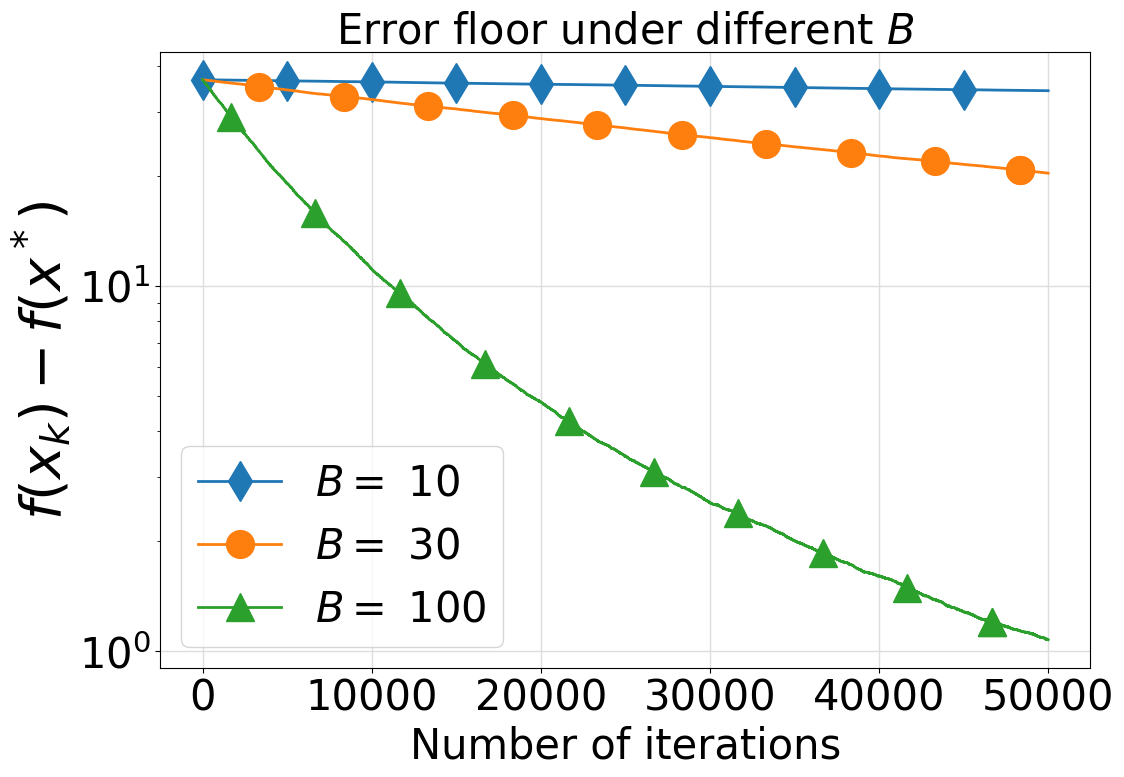

In [52]:
plot_graph_Bs(Bs[:], Bs_comp[:])

In [3]:
d = 32
p = 32
Q = 10

model = Experiments(d,p,Q)

In [12]:
# beta, gamma, Iterations, Batch, stepsize
beta = 5
gamma = 1e-1
Iterations = 10000
stepsize = 0.00001
Bs = [100, 1000, 10000]
Bs_comp = []

In [14]:
for B in Bs:
    Bs_comp.append(model.Our_algorithm(beta, gamma, Iterations, B, (12 * d * 125 / B)))

100%|██████████| 10000/10000 [50:41<00:00,  3.29it/s]


In [15]:
def plot_graph_Bs(Bs, Bs_comp):
    fig = plt.figure(figsize=(12, 8))

    plt.title(r'Error floor under different $B$', fontsize=30)
    marker = itertools.cycle(('d', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    X = np.arange(len(Bs_comp[0]))
    length = len(Bs_comp[0])
    
    for i in range(len(Bs)):
        plt.semilogy(X, Bs_comp[i], marker=next(marker),
            markersize=20, markevery=range(-i*int(length/(10*3)), length, int(length/10)), 
            label=f'$B = $ {Bs[i]}', linewidth=2)
    
    # plt.legend(bbox_to_anchor=(0.32,0), loc=4, fontsize=10)
    plt.legend(loc='best', fontsize=30)

    plt.xlabel(r'Number of iterations', fontsize=30)
    plt.ylabel(r"$f(x_k)-f(x^*)$", fontsize=40)

    plt.xticks(fontsize=30)
    _ = plt.yticks(fontsize=30)
      
    ax = fig.gca()
    ax.xaxis.offsetText.set_fontsize(28)
    ax.yaxis.offsetText.set_fontsize(28)
    ax.grid(which='major', color='#DDDDDD', linewidth=1)

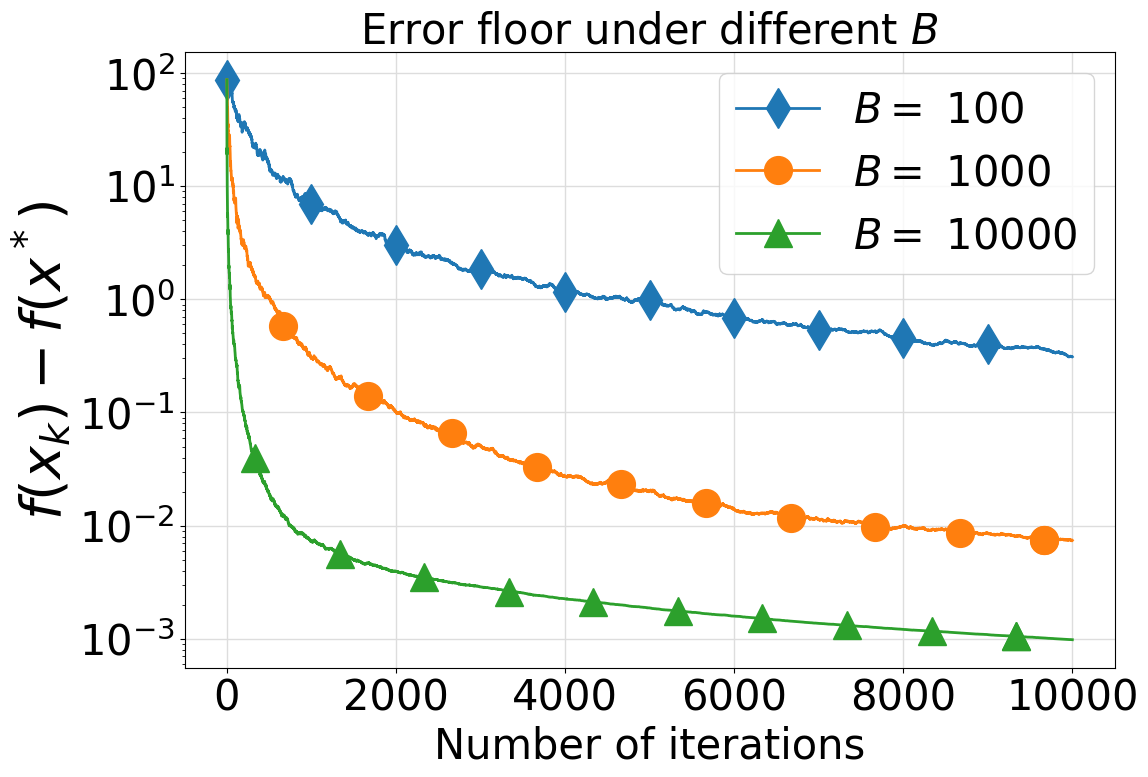

In [18]:
plot_graph_Bs(Bs[1:], Bs_comp[1:])

In [ ]:
results = model.Paper_comp(beta=5, gamma=1e-1, Iterations=int(5e5), Batch=10, coeff_our=1e3, coeff_gorb=0.1, coeff_chen=1e-4)

100%|██████████| 500000/500000 [09:26<00:00, 882.35it/s]


In [ ]:
def plot_graph(X_graf, Y_graf_Paper, Y_graf_Gorb, Y_graf_Chen):
    fig = plt.figure(figsize=(12, 8))

    plt.title(r'Synthetic', fontsize=30)
    marker = itertools.cycle(('d', 'o', '^', 's', '*', 'p', '<', '>', '^'))

    length = len(X_graf)

    plt.semilogy(X_graf, Y_graf_Paper, marker=next(marker),
            markersize = 20, markevery=range(-0*int(length/(10*3)), length, int(length/10)), 
            label='ZO-AccSGD', linewidth=2)
    plt.semilogy(X_graf, Y_graf_Gorb, marker=next(marker),
            markersize = 20, markevery=range(-1*int(length/(10*3)), length, int(length/10)), 
            label='ARDFDS', linewidth=2)
    plt.semilogy(X_graf, Y_graf_Chen, marker=next(marker),
            markersize = 20, markevery=range(-2*int(length/(10*3)), length, int(length/10)), 
            label='ZO-VARAG', linewidth=2)
    
    plt.legend(bbox_to_anchor=(1,0.35), loc=4, fontsize=30)

    plt.xlabel(r'Number of iterations', fontsize=30)
    plt.ylabel(r"$f(x_k)-f(x^*)$", fontsize=40)

    plt.xticks(fontsize=30)
    _ = plt.yticks(fontsize=30)
      
    ax = fig.gca()
    ax.xaxis.offsetText.set_fontsize(28)
    ax.yaxis.offsetText.set_fontsize(28)
    ax.grid(which='major', color='#DDDDDD', linewidth=1)

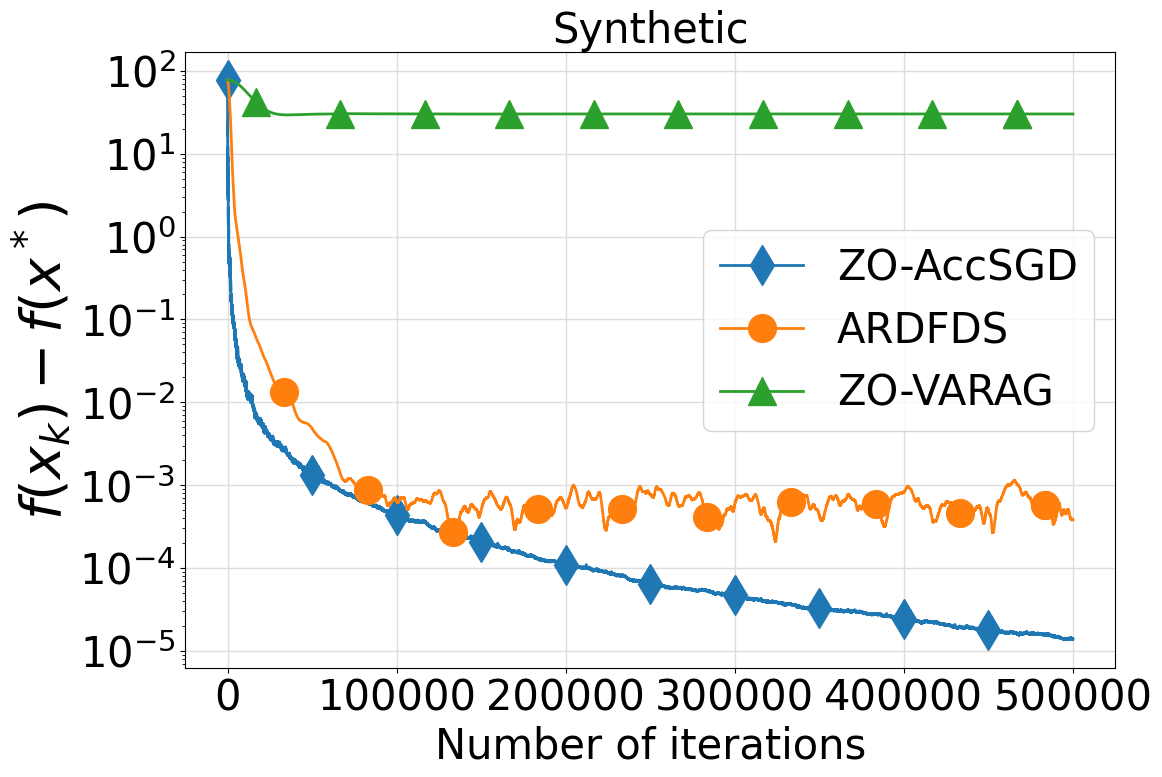

In [ ]:
plot_graph(results[0], results[1], results[2], results[3])

In [19]:
d = 4
p = 4
Q = 10

model = Experiments(d,p,Q)

In [20]:
beta = 5
gamma = 1e-1
Iterations = 10000
stepsize = 0.00001
Bs = [60, 600, 6000]
Bs_comp = []

In [21]:
for B in Bs:
    Bs_comp.append(model.Our_algorithm(beta, gamma, Iterations, B, 10 * (12 * d * 125 / B)))

100%|██████████| 10000/10000 [35:18<00:00,  4.72it/s]


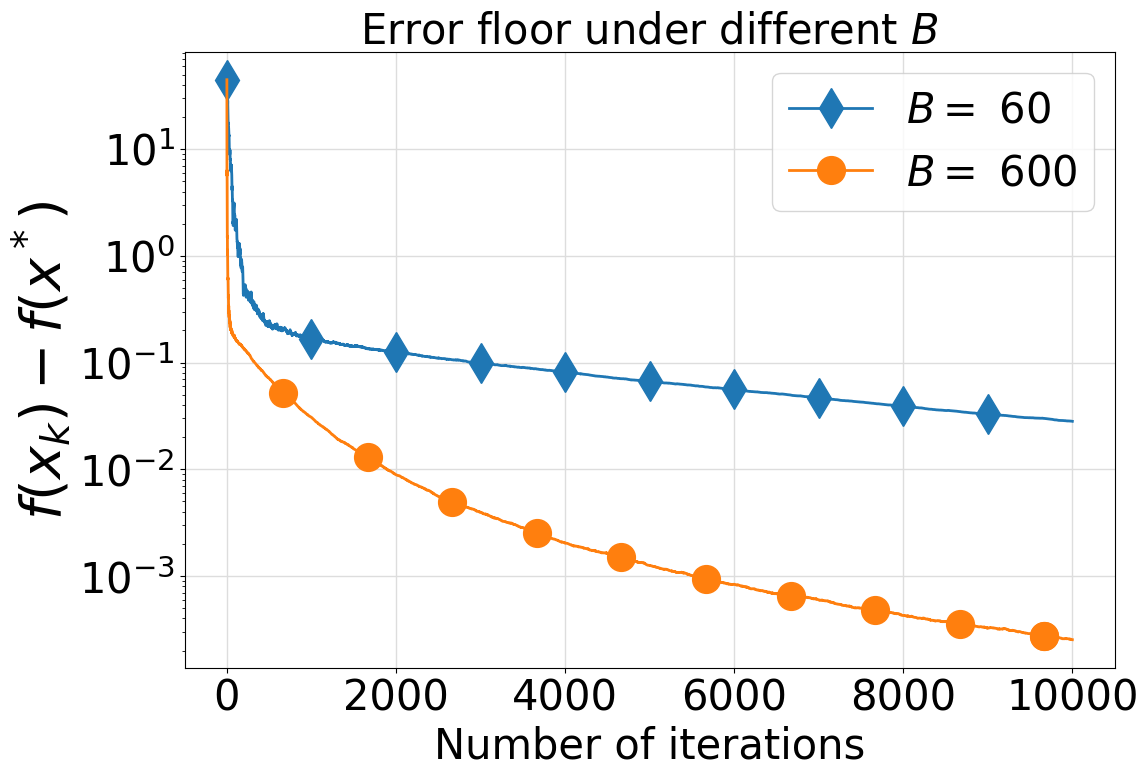

In [23]:
plot_graph_Bs(Bs[:2], Bs_comp[:2])